# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [52]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle

In [53]:
tf.__version__

'1.11.0'

## Import the Data

In [54]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [55]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [56]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [57]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [58]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [59]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [60]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [61]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [62]:
x_train.shape

(60000, 784)

In [63]:
x_test.shape

(10000, 784)

## Reshape the labels

In [64]:
y_train.shape

(60000,)

In [65]:
y_test.shape

(10000,)

In [66]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [67]:
num_classes = len(np.unique(y_train))
num_classes

10

In [68]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [69]:
y_train.shape

(60000, 10)

In [70]:
y_test.shape

(10000, 10)

In [71]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

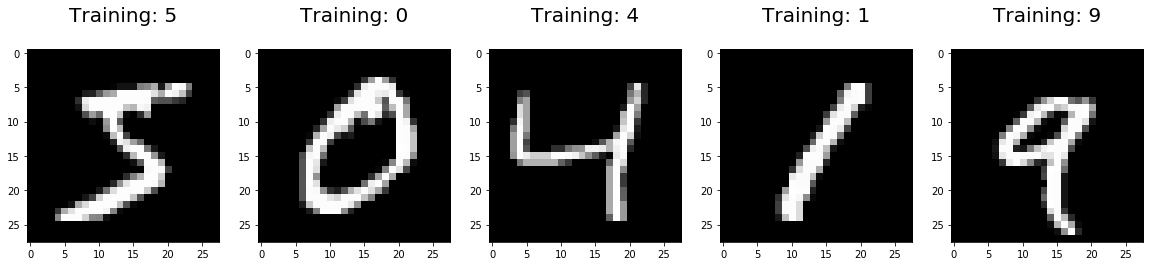

In [72]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [73]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 1

# size of our mini batch
BATCH_SIZE = len(x_train)

# hidden layer 1
n1=300

In [74]:
BATCH_SIZE, EPOCHS

(60000, 1)

## Using tf.data.Dataset

In [75]:
def input_dataset_fn(x_data, y_data, is_training=True, batch_size=1024):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    if is_training:
        dataset = dataset.shuffle(1000) # depends on sample size
        #dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
        
    # caching data
    dataset = dataset.cache()
    
    # create batches of data
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    # automatically refill the data queue when empty
    dataset = dataset.repeat()
    
    # prefetch data for faster consumption
    # based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(tf.contrib.data.AUTOTUNE)

    return dataset

In [76]:
training_dataset = input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE)
testing_dataset = input_dataset_fn(x_test, y_test, is_training=False, batch_size=BATCH_SIZE)

In [77]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return
        

## Defined our model

In [78]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp: keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [79]:
# build the model
model = baseline_model()

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [81]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_variable_with_custom_getter',
 '_assert_input_compatibility',
 '_base_init',
 '_build_input_shape',
 '_call_and_compute_mask',
 '_call_convention',
 '_check_trainable_weights_consistency',
 '_checkpoint_dependencies',
 '_checkpointable_saver',
 '_collected_trainable_weights',
 '_compile_distributed_model',
 '_compute_output_and_mask_jointly',
 '_compute_previous_mask',
 '_dataset_iterator_cache',
 '_deferred_dependencies',
 '_determine_call_convention',
 '_distribution_standardize_user_data',
 '_distribution_strategy',
 '_dtype',
 '_eager_set_inputs',
 '_e

## Store the original weights

In [82]:
initial_weights = model.get_weights()

## Fit the model using numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [83]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.36592
Epoch 1/1
 accurary on the training set 0.5496
 accurary on the testing set 0.5507
 - 8s - loss: 2.3659 - acc: 0.1169 - val_loss: 1.8148 - val_acc: 0.5507


In [84]:
print(hist.history)

{'val_loss': [1.8148441314697266], 'val_acc': [0.5507000088691711], 'loss': [2.3659250736236572], 'acc': [0.11693333089351654]}


In [85]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8148451826095582
Test accuracy: 0.5507


In [86]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 1.8132999474843343
Train accuracy: 0.5495833333333333


## Fit the model using data.dataset

In [87]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(training_dataset.make_one_shot_iterator(),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=testing_dataset.make_one_shot_iterator(),
               validation_steps=len(x_test) // BATCH_SIZE,
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS,
               verbose = 2)

Epoch 1/1
 - 29s - loss: 2.3659 - acc: 0.1169


In [88]:
print(hist.history)

{'loss': [2.3659250736236572], 'acc': [0.11693333089351654]}


In [89]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8155830837249756
Test accuracy: 0.5504


In [90]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 1.813952548122406
Train accuracy: 0.5496833333333333


## Fit the model using data.dataset

In [91]:
! rm -r ./results/Models/Mnist/ckpt

In [92]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

In [93]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', './results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', './results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
FLAGS = tf.app.flags.FLAGS

In [94]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [95]:
time_hist = TimeHistory()

In [96]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
strategy=None
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

In [97]:
# Set to the original weights for testing other pipelines
#model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': './results/Models/Mnist/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb46d0f3c8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [98]:
!ls ./results/Models/Mnist/ckpt

keras


In [99]:
def get_train_input_fn():
    return input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE)

In [ ]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=1,
                            hooks=[time_hist])

In [ ]:
estimator_model.evaluate(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=False, batch_size=BATCH_SIZE),
                         steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-17-12:10:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\C172685\AppData\Local\Temp\1\tmp7yxfhpa6\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
